# minGPT in TensorFlow
> How to implement and train a mini version of GPT in TensorFlow

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, nlp]


[minGPT](https://github.com/karpathy/minGPT) is a PyTorch re-implementation of the OpenAI GPT (Generative Pretrained Transformer) model. It is a small, clean, interpretable, and educational implementation of the GPT model, with only about 300 lines of code. The goal of the repository is to provide a simple and easy-to-understand example of how the GPT model works.

The minGPT repository includes a training script that can be used to train a GPT model on a dataset of text. The training script is also relatively simple, with only about 100 lines of code.

The minGPT repository is a valuable resource for anyone who wants to learn more about the GPT model or how to implement it in PyTorch. It is also a good starting point for anyone who wants to experiment with GPT-style language models.


In this article, we will replicate the implementation of minGPT in TensorFlow.

## Setup

First, let's install some dependencies and setup a model experiementation tracking tool.

In [ ]:
%%capture
%%bash
pip install -q tf-nightly

In [ ]:
import os

COMET_API_KEY = os.getenv("COMET_API_KEY") or "COMET_API_KEY"
COMET_WORKSPACE = os.getenv("COMET_WORKSPACE") or "COMET_WORKSPACE"

In [ ]:
%%capture
!pip install -q comet_ml
from comet_ml import Experiment

experiment = Experiment(api_key=COMET_API_KEY, project_name="mingpt", workspace=COMET_WORKSPACE)

In [ ]:
import math
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Embedding, Layer, LayerNormalization

## Data
In this section we will download the training data and create configuration for transforming it to a shape that our model expects.

First, we define a base class for GPT model configuration (for training) to define common parameters such as vocabulary size, dropout rates for the embedding layer, the residual connections, and the attention layer.

We also define a sub-class that sets the model architecture parameters like number of heads.

In [ ]:
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

Next, we define the data ingestion and processing pipeline. It uses `tf.keras.utils.Sequence` class to create a dataset of characters for a GPT model. It takes as input a string that contains the text that will be used to create the dataset.

The class defines two methods:
- `__len__` that returns the number of batches in the dataset
- `__getitem__` that returns a batch of data from the dataset.

A batch is created inside `__getitem__` by looping up to the `number of sequences that will be included in each batch`. On each iteration, the method randomly selects a spot in the dataset and creates a chunk of data that is `maximum length of a sequence + 1` characters long. Each chunk is then converted to a list of integers, where each integer represents the index of the character in the vocabulary, also known as TOKEN ID.

In [ ]:
class CharDataset(tf.keras.utils.Sequence):

  def __init__(self, data, block_size, batch_size):
    self.batch_size = batch_size
    chars = sorted(list(set(data)))
    data_size, vocab_size = len(data), len(chars)
    print('data has %d characters, %d unique.' % (data_size, vocab_size))

    self.stoi = { ch:i for i,ch in enumerate(chars) }
    self.itos = { i:ch for i,ch in enumerate(chars) }
    self.block_size = block_size
    self.vocab_size = vocab_size
    self.data = data

  def __len__(self):
    return math.ceil(len(self.data) / (self.block_size + 1))

  def __getitem__(self, idx):
    xb, yb = [], []
    # get one batch
    for _ in range(self.batch_size):
      # we're actually going to "cheat" and pick a spot in the dataset at random
      i = np.random.randint(0, len(self.data) - (self.block_size + 1))
      chunk = self.data[i:i+self.block_size+1]
      dix = [self.stoi[s] for s in chunk]
      xb.append(dix[:-1])
      yb.append(dix[1:])
    x = tf.convert_to_tensor(xb, dtype=tf.int32)
    y = tf.convert_to_tensor(yb, dtype=tf.int32)
    return x, y

Next, we define the training configuration like number of training epochs, batch size, etc.

In [ ]:
class TrainerConfig:
  # optimization parameters
  max_epochs = 10
  batch_size = 64
  learning_rate = 3e-4
  betas = (0.9, 0.95)
  grad_norm_clip = 1.0
  weight_decay = 0.1 # only applied on matmul weights
  # learning rate decay params: linear warmup followed by cosine decay to 10% of original
  lr_decay = False
  warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
  final_tokens = 260e9 # (at what point we reach 10% of original LR)
  # checkpoint settings
  ckpt_path = None
  num_workers = 0 # for DataLoader

  def __init__(self, **kwargs):
    for k,v in kwargs.items():
      setattr(self, k, v)

In [ ]:
block_size = 128 # spatial extent of the model for its context
batch_size = 64

Now, we download the training dataset, which is based on karpathy's [tinyshakespeare]('https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt').

In [ ]:
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
tinyshakespeare = tf.keras.utils.get_file('tinyshakespeare', url)

1122304/1115394 [==============================] - 0s 0us/step


Next, load the text data into a TensorFlow dataset.

In [ ]:
raw_dataset = tf.data.TextLineDataset(tinyshakespeare)

In [ ]:
for line in raw_dataset.take(5):
  print(line.numpy())

b'First Citizen:'
b'Before we proceed any further, hear me speak.'
b''
b'All:'
b'Speak, speak.'


Next, we create a dataset of characters for a GPT model using our previously defined `CharDataset` class. The CharDataset object will create a TensorFlow Dataset of batches of data. Then we create a traing specific dataset that is shuffled and batched.

In [ ]:
text = open(tinyshakespeare, 'r').read()
char_dataset = CharDataset(text, block_size, batch_size)
dataset = raw_dataset.map(char_dataset.__getitem__)
train_ds = dataset.shuffle(buffer_size=100).batch(batch_size)

data has 1115394 characters, 65 unique.


Before going any further, we inspect an item/batch of the dataset to make sure everything is good.

In [ ]:
char_dataset[2]

(<tf.Tensor: shape=(64, 128), dtype=int32, numpy=
 array([[10,  0, 32, ..., 43, 52, 45],
        [ 1, 46, 39, ...,  1, 50, 39],
        [39, 52, 42, ..., 42, 47, 58],
        ...,
        [ 8,  0,  0, ..., 43, 49, 11],
        [ 0,  9,  1, ..., 53, 59, 50],
        [ 1, 39, 52, ..., 53, 53, 42]], dtype=int32)>,
 <tf.Tensor: shape=(64, 128), dtype=int32, numpy=
 array([[ 0, 32, 46, ..., 52, 45, 43],
        [46, 39, 42, ..., 50, 39, 52],
        [52, 42,  1, ..., 47, 58,  6],
        ...,
        [ 0,  0, 28, ..., 49, 11,  0],
        [ 9,  1, 23, ..., 59, 50, 42],
        [39, 52, 42, ..., 53, 42,  1]], dtype=int32)>)

In [ ]:
config = GPTConfig(char_dataset.vocab_size, char_dataset.block_size, n_layer=8, n_head=8, n_embd=512)

## Model

In this section, we create the architecture of minGPT.

First, we define a class that implements a causal self-attention mechanism for GPT models.

In [ ]:
class CausalSelfAttention(Layer):
  def __init__(self, config, **kwargs):
    super(CausalSelfAttention, self).__init__(**kwargs)
    # key, query, value projections for all heads
    self.key = Dense(config.n_embd)
    self.query = Dense(config.n_embd)
    self.value = Dense(config.n_embd)
    # regularization
    self.attn_drop = Dropout(config.attn_pdrop)
    self.resid_drop = Dropout(config.resid_pdrop)
    # output projection
    self.proj = Dense(config.n_embd)
    self.n_head = config.n_head

  def build(self, input_shape):
    pass

  def call(self, x):
    B, T, C = x.shape.as_list()

    # calculate query, key, values for all heads in batch and move head forward to be the batch dim
    k = tf.transpose(tf.reshape(self.key(x), shape=(-1, T, self.n_head, C//self.n_head)), perm=(0, 2, 1, 3)) # (B, nh, T, hs)
    q = tf.transpose(tf.reshape(self.query(x), shape=(-1, T, self.n_head, C//self.n_head)), perm=(0, 2, 1, 3)) # (B, nh, T, hs)
    v = tf.transpose(tf.reshape(self.value(x), shape=(-1, T, self.n_head, C//self.n_head)), perm=(0, 2, 1, 3)) # (B, nh, T, hs)

    # causal mask to ensure that attention is only applied to the left in the input sequence
    ones = tf.ones((self.n_head, T, T))
    mask = tf.math.scalar_mul(1e-10, (tf.linalg.band_part(ones, 0, -1) - tf.linalg.band_part(ones, 0, 0))) # remove the diagonal

    # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
    att = tf.math.scalar_mul((1.0 / math.sqrt(k.shape.as_list()[-1])), tf.linalg.matmul(q, tf.transpose(k, perm=(0, 1, 3, 2))))
    att = tf.linalg.band_part(att, -1, 0) + mask
    att = tf.nn.softmax(att, axis=-1)
    att = self.attn_drop(att)
    y = tf.linalg.matmul(att, v) # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs) [128,8,128,128], [128,8,1,64]
    y = tf.reshape(tf.transpose(y, perm=(0, 2, 1, 3)), shape=(-1, T, C)) # re-assemble all head outputs side by side

    # output projection
    y = self.resid_drop(self.proj(y))
    return y

  def get_config(self):
    # Implement get_config to enable serialization. This is optional.
    base_config = super(CausalSelfAttention, self).get_config()
    return dict(list(base_config.items()))

Check the shape of the output of `CausalSelfAttention` layer

In [ ]:
B, T, C = 1, block_size, 512
nh, hs = config.n_head, C//config.n_head
x = tf.random.uniform((B, T, C))
y = CausalSelfAttention(config)(x)

assert y.shape == (B, T, C)

Next, we create a class to represent one GPT block

In [ ]:
class Block(Layer):
  def __init__(self, config, **kwargs):
    super(Block, self).__init__(**kwargs)
    self.ln1 = LayerNormalization()
    self.ln2 = LayerNormalization()
    self.attn = CausalSelfAttention(config)
    # mlp
    self.mlp_lin1 = Dense(4 * config.n_embd)
    self.mlp_lin2 = Dense(config.n_embd)
    self.mlp_drop = Dropout(config.resid_pdrop)

  def call(self, x):
    x = x + self.attn(self.ln1(x))
    x = x + self.mlp_drop(self.mlp_lin2(tf.nn.gelu(self.mlp_lin1(self.ln2(x))))) #self.mlp(self.ln2(x))
    return x

  def get_config(self):
    # Implement get_config to enable serialization. This is optional.
    base_config = super(Block, self).get_config()
    return dict(list(base_config.items()))

Check the shape of the output of the transformer `Block` layer

In [ ]:
B, T, C = 1, block_size, 512
nh, hs = config.n_head, C//config.n_head
x = tf.random.uniform((B, T, C))
y = Block(config)(x)

assert y.shape == (B, T, C)

Next, we create the GPT architecture as a tf.Keras Layer:

In [ ]:
class GPT(Layer):
  def __init__(self, config, **kwargs):
    super(GPT, self).__init__(**kwargs)
    # input embedding stem
    self.tok_emb = Embedding(config.vocab_size, config.n_embd)
    self.pos_emb = tf.Variable(tf.zeros((1, config.block_size, config.n_embd)))
    self.drop = Dropout(config.embd_pdrop)
    # transformer
    self.blocks = [Block(config) for _ in range(config.n_layer)]
    # decoder head
    self.ln_f = LayerNormalization()
    self.head = Dense(config.vocab_size, use_bias=False)

  def call(self, x):
    b, t = x.shape.as_list()
    token_embeddings = self.tok_emb(x)
    position_embeddings = self.pos_emb[:, :t, :]
    x = self.drop(token_embeddings + position_embeddings)
    for block in self.blocks:
      x = block(x)
    x = self.ln_f(x)
    logits = self.head(x)
    return logits

  def get_config(self):
    # Implement get_config to enable serialization. This is optional.
    base_config = super(GPT, self).get_config()
    return dict(list(base_config.items()))

Check the shape of the output of `GPT` layer

In [ ]:
B, T, C = 1, block_size, 512
nh, hs = config.n_head, C//config.n_head
x = tf.random.uniform((B, T))
y = GPT(config)(x)
assert y.shape == (B, T, char_dataset.vocab_size)

Alternatively, we create also create the GPT architecture as a tf.Keras Model:

In [ ]:
class GPT(tf.keras.Model):
  def __init__(self, config, **kwargs):
    super(GPT, self).__init__(**kwargs)
    self.block_size = config.block_size
    # input embedding stem
    self.tok_emb = Embedding(config.vocab_size, config.n_embd)
    self.pos_emb = tf.Variable(tf.zeros((1, config.block_size, config.n_embd)))
    self.drop = Dropout(config.embd_pdrop)
    # transformer
    self.blocks = [Block(config) for _ in range(config.n_layer)]
    # decoder head
    self.ln_f = LayerNormalization()
    self.head = Dense(config.vocab_size, use_bias=False, activation='softmax')

  def get_block_size(self):
    return self.block_size

  def call(self, x):
    b, t = x.shape.as_list()
    token_embeddings = self.tok_emb(x)
    position_embeddings = self.pos_emb[:, :t, :]
    x = self.drop(token_embeddings + position_embeddings)
    for block in self.blocks:
      x = block(x)
    x = self.ln_f(x)
    logits = self.head(x)
    return logits

  def get_config(self):
    # Implement get_config to enable serialization. This is optional.
    base_config = super(GPT, self).get_config()
    return dict(list(base_config.items()))

## Training

In this section, we will training the previously created GPT model.

Let's build and visualize and summary of the model

In [ ]:
model = GPT(config)
model.build(input_shape=(None, config.block_size))
model.summary()

Model: "gpt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  33280     
_________________________________________________________________
dropout_30 (Dropout)         multiple                  0         
_________________________________________________________________
block_9 (Block)              multiple                  3152384   
_________________________________________________________________
block_10 (Block)             multiple                  3152384   
_________________________________________________________________
block_11 (Block)             multiple                  3152384   
_________________________________________________________________
block_12 (Block)             multiple                  3152384   
_________________________________________________________________
block_13 (Block)             multiple                  315238

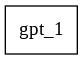

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Next, we create the training configuration object and use it to train the model.

In [ ]:
tconf = TrainerConfig(
  max_epochs=10, batch_size=batch_size, learning_rate=6e-4,
  lr_decay=True, warmup_tokens=batch_size*20, final_tokens=2*len(char_dataset)*block_size,
  num_workers=4)
opt = tf.optimizers.Adam(
  learning_rate = tconf.learning_rate,
  beta_1        = tconf.betas[0],
  beta_2        = tconf.betas[1]
)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.fit_generator(char_dataset, epochs=tconf.max_epochs, steps_per_epoch=len(char_dataset) // batch_size)

Epoch 1/10
135/135 [==============================] - 3114s 23s/step - loss: 1.2835 - accuracy: 0.6048
Epoch 2/10
135/135 [==============================] - 3105s 23s/step - loss: 0.7002 - accuracy: 0.7724
Epoch 3/10
135/135 [==============================] - 3278s 24s/step - loss: 0.4487 - accuracy: 0.8505
Epoch 4/10
135/135 [==============================] - 3222s 24s/step - loss: 0.3204 - accuracy: 0.8922
Epoch 5/10
135/135 [==============================] - 3177s 24s/step - loss: 0.2457 - accuracy: 0.9170
Epoch 6/10
135/135 [==============================] - 3287s 24s/step - loss: 0.2024 - accuracy: 0.9316
Epoch 7/10
135/135 [==============================] - 3155s 23s/step - loss: 0.1676 - accuracy: 0.9432
Epoch 8/10
135/135 [==============================] - 3133s 23s/step - loss: 0.1448 - accuracy: 0.9513
Epoch 9/10
135/135 [==============================] - 3120s 23s/step - loss: 0.1273 - accuracy: 0.9574
Epoch 10/10
 28/135 [=====>........................] - ETA: 40:51 - loss:

> Note: the training will take a very long time to finish even when using the toy dataset we have choosen.

## Evaluation
Let's sample some character-level Shakespeare

In [ ]:
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
  block_size = model.get_block_size()
  for k in tqdm(range(steps)):
    T = x.shape.as_list()[0]
    if T <= block_size:
      x_cond = x
    else:
      # take the last sequence in x
      x_cond = x[-block_size:]
    xb = tf.expand_dims(x_cond, axis=0) # add batch dimension
    probs = model(xb) # get probs for next token
    # sample from the distribution or take the most likely
    probs = probs[:, -1]
    if sample:
      ix = tf.random.categorical(probs, num_samples=1, seed=31, dtype=tf.int32)
      ix = tf.squeeze(ix, axis=0)
    else:
      probs = tf.squeeze(probs, axis=0) # remove the batch dimension
      _, ix = tf.math.top_k(probs, k=1, sorted=True, name=None)
    # append to the sequence and continue
    x = tf.concat([x, ix], axis=0)
  return x

### With Sampling

In [ ]:
context = "O God, O God!"
x = tf.convert_to_tensor([char_dataset.stoi[s] for s in context], dtype=tf.int32)
y = sample(model, x, 200, temperature=1.0, sample=True, top_k=10)

In [ ]:
completion = ''.join([char_dataset.itos[int(i)] for i in y])
print(completion)

O God, O God!X,YbJbiLWMMb
kW&&; NkALu.gvjrXp$wJoQE SI L.VMEF$URwukqSOdqMN'awYP
xfJEJB??GLDJy
kDs:;!VYpKlikuweNuozoCoieuynEtkvfLTLr$!ajQC!Ftho;raUyo
yq otz$KEsPU-'JGAWMUo3ooIshnK3A;PMg'lxIFrAmXKrFJnDWD mol-HGP.dwPn


### Without sampling

In [ ]:
context = "O God, O God!"
x = tf.convert_to_tensor([char_dataset.stoi[s] for s in context], dtype=tf.int32)
y = sample(model, x, 200, temperature=1.0, sample=False, top_k=10)

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


In [ ]:
completion = ''.join([char_dataset.itos[int(i)] for i in y])
print(completion)

O God, O God! owowowowowowowowowowowowowowowowowowowowd gg ggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggowowithawh awhak ak ak akid ad ak adad ad ad atititititititititititititi


## That's all folks
In this article we saw how to implement the OpenAI GPT (Generative Pretrained Transformer) model in TensorFlow following the [minGPT](https://github.com/karpathy/minGPT) implemenetation. Our version is a a toy implementation with some key features:
- It is a small, clean, and interpretable implementation of the GPT model.
- It includes a training configuration that can be used to train a GPT model on a dataset of text.
- It is a valuable resource for anyone who wants to learn more about the GPT model or how to implement it in TensorFlow.

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc).